In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version 2.3.0
Num GPUs Available:  1


In [5]:
# creating 'data flow' for training data from data directory using ImageDataGenerator class

from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMAGE_SIZE = [128, 128]

# we will use data augmentation for train dataset
train_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.10, 
                                          height_shift_range=0.10,zoom_range=.10, horizontal_flip=True,
                                          samplewise_center = True, samplewise_std_normalization = True)

train_data_flow = train_data_generator.flow_from_directory(directory = '/catsnotcats/data/data/train', 
                                               classes=['not_cats', 'cats'], target_size = IMAGE_SIZE,
                                               color_mode="rgb",batch_size = BATCH_SIZE,
                                               class_mode='binary',shuffle = True,seed=42)

Found 17502 images belonging to 2 classes.


In [6]:
# creating 'data flow' for validation data from data directory using ImageDataGenerator class

valid_data_generator = ImageDataGenerator(rescale=1./255, samplewise_center = True, samplewise_std_normalization = True)

valid_data_flow = valid_data_generator.flow_from_directory(directory = '/catsnotcats/data/data/validation', 
                                               classes=['not_cats', 'cats'], target_size = IMAGE_SIZE,
                                               color_mode="rgb",batch_size = BATCH_SIZE,
                                               class_mode='binary',shuffle = True,seed=42)

Found 7498 images belonging to 2 classes.


In [7]:
# training data flow without augmentation

demonstrative_data_generator = ImageDataGenerator(rescale=1./255)

demonstrative_data_flow = demonstrative_data_generator.flow_from_directory(directory = '/catsnotcats/data/data/train', 
                                                               classes=['not_cats', 'cats'], target_size = IMAGE_SIZE,
                                                               color_mode="rgb",batch_size = BATCH_SIZE,
                                                               class_mode='binary',shuffle = True,seed=42)

Found 17502 images belonging to 2 classes.


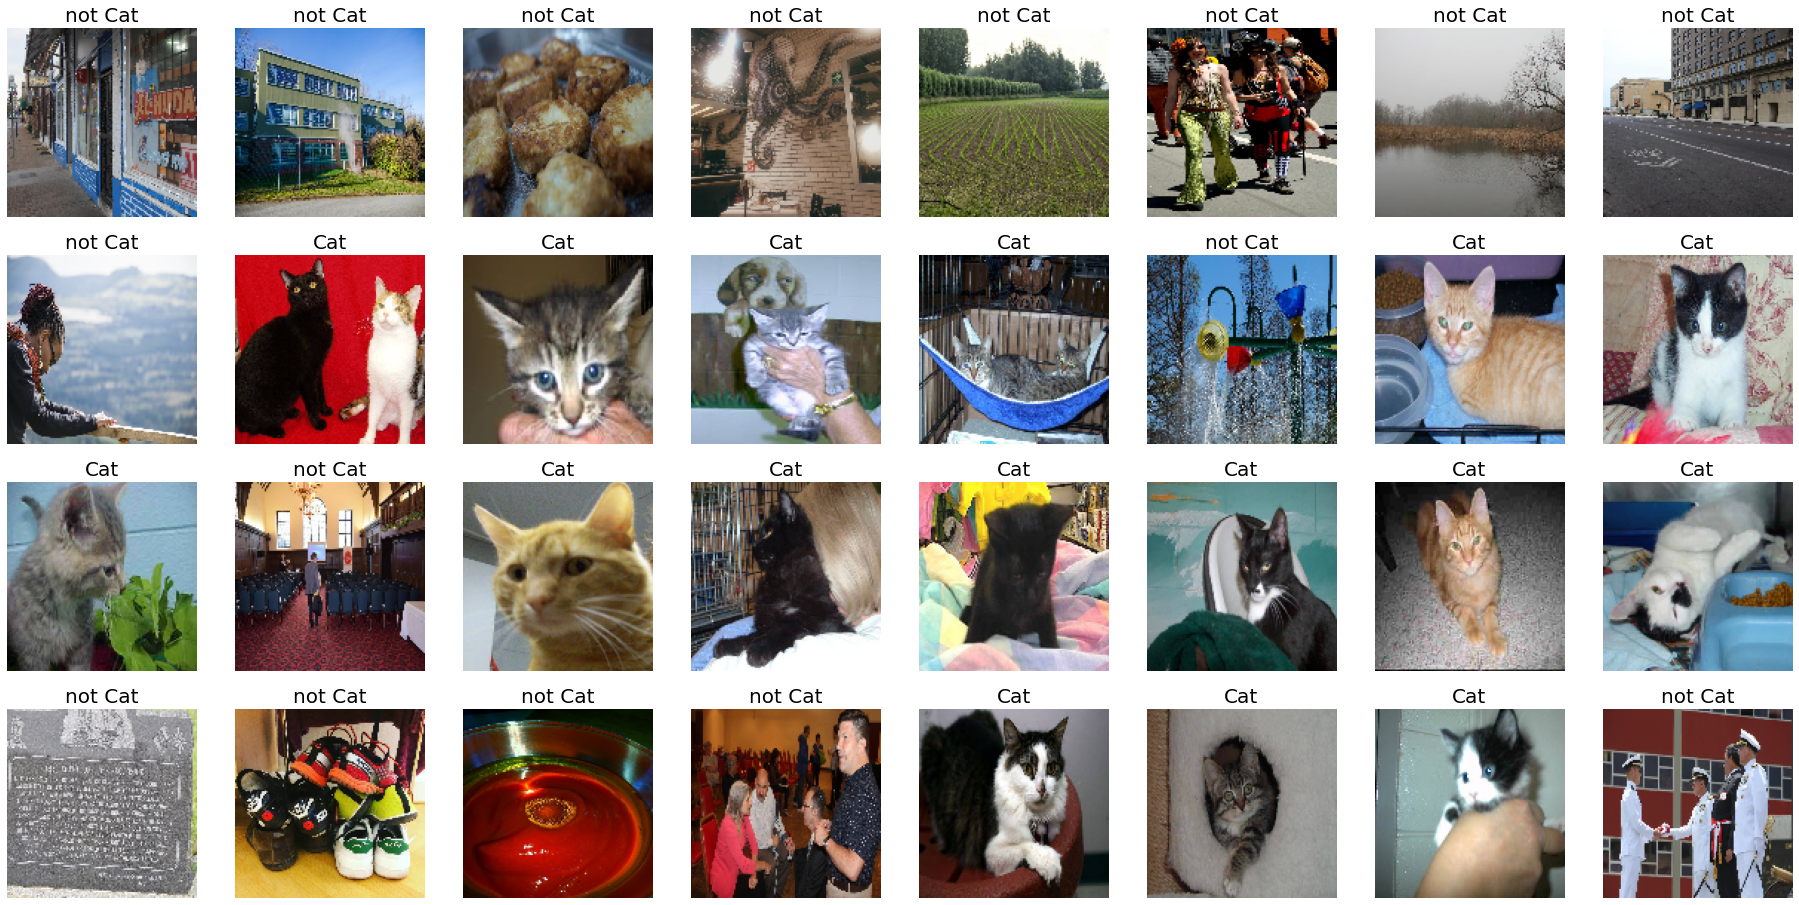

In [8]:
# plot images from tain data flow without augmentation

def plot_multiple_images(images_batch, n = BATCH_SIZE):
    n_cols = 8
    n_rows = n / 8
    plt.figure(figsize=(4*n_cols, 4*n_rows))
    images, labels = images_batch
    for i in range(n):
        index = i 
        image = tf.expand_dims(images[index], 0).numpy()
        image = np.squeeze(image, axis=0)
        label = labels[index]
        if label == 0:
            title = 'not Cat'
        else:
            title = 'Cat'
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(title, fontsize=int(20), color='black')
        plt.imshow(image)
        plt.axis("off")
        
plot_multiple_images(next(demonstrative_data_flow), n = 32)

Learning rate schedule: 1e-05 to 5e-05 to 1.11e-05


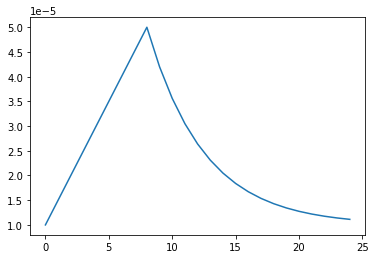

In [9]:
# create learning rate schedule

EPOCHS = 25

LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 8
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
        
@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [11]:
# We will use MobileNetV2 network as basis for our classifier.

model_base = tf.keras.applications.MobileNetV2(weights=None, include_top=False ,input_shape=[*IMAGE_SIZE, 3])
model_base.trainable = True 

model = tf.keras.Sequential([model_base,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [14]:
model_base.load_weights('model_base_weights.h5')

In [15]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience= 10, restore_best_weights=True, 
                                                         monitor='val_accuracy', mode='auto')

EPOCHS = 25
STEPS_PER_EPOCH = 17502 // BATCH_SIZE
history = model.fit(train_data_flow, shuffle=True, steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,validation_data=valid_data_flow, callbacks=[lr_callback, earlystoping_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-05, shape=(), dtype=float32).
Epoch 1/25
273/273 [==============================] - 372s 1s/step - loss: 0.6791 - accuracy: 0.5973 - val_loss: 0.6745 - val_accuracy: 0.6107

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(1.5e-05, shape=(), dtype=float32).
Epoch 2/25
273/273 [==============================] - 257s 940ms/step - loss: 0.6246 - accuracy: 0.7907 - val_loss: 0.6058 - val_accuracy: 0.7966

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(2e-05, shape=(), dtype=float32).
Epoch 3/25
273/273 [==============================] - 253s 927ms/step - loss: 0.5114 - accuracy: 0.8678 - val_loss: 0.4862 - val_accuracy: 0.7999

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(2.5e-05, shape=(), dtype=float32).
Epoch 4/25
273/273 [==============================] - 254s 930ms/step - loss: 0.3600 - accuracy: 0.8916 - val_loss: 0.4329 - val_accuracy: 0.

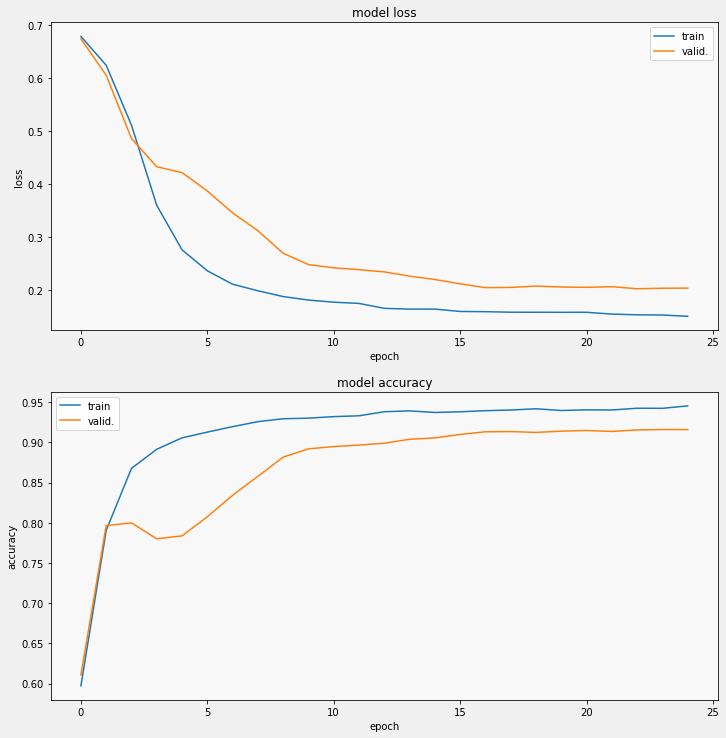

In [16]:
# Display training curves for our model

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [28]:
# we will run the fit method again in order to achieve the highest possible accuracy by activating earlystopping callback

earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience= 5, restore_best_weights=True, 
                                                         monitor='val_accuracy', mode='auto')

EPOCHS = 25
STEPS_PER_EPOCH = 17502 // BATCH_SIZE
history2 = model.fit(train_data_flow, shuffle=True, steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,validation_data=valid_data_flow, callbacks=[lr_callback, earlystoping_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-05, shape=(), dtype=float32).
Epoch 1/25
273/273 [==============================] - 237s 869ms/step - loss: 0.1477 - accuracy: 0.9443 - val_loss: 0.1980 - val_accuracy: 0.9182

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(1.5e-05, shape=(), dtype=float32).
Epoch 2/25
273/273 [==============================] - 240s 878ms/step - loss: 0.1453 - accuracy: 0.9444 - val_loss: 0.1971 - val_accuracy: 0.9188

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(2e-05, shape=(), dtype=float32).
Epoch 3/25
273/273 [==============================] - 241s 882ms/step - loss: 0.1434 - accuracy: 0.9480 - val_loss: 0.1923 - val_accuracy: 0.9206

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(2.5e-05, shape=(), dtype=float32).
Epoch 4/25
273/273 [==============================] - 241s 884ms/step - loss: 0.1400 - accuracy: 0.9477 - val_loss: 0.1853 - val_accuracy:

In [29]:
# Evaluate trained classifier

model_loss, model_accuracy = model.evaluate(valid_data_flow)

118/118 [==============================] - 50s 423ms/step - loss: 0.1853 - accuracy: 0.9253


In [30]:
# make predictions on validation set

valid_data_flow_2 = valid_data_generator.flow_from_directory(directory = '/catsnotcats/data/data/validation', 
                                                           classes=['not_cats', 'cats'], target_size = IMAGE_SIZE,
                                                           color_mode="rgb",batch_size = 7498,
                                                           class_mode='binary',shuffle = True,seed=42)


images, valid_labels = next(valid_data_flow_2) 
valid_proba = model.predict(images)
valid_predictions = np.around(valid_proba)

Found 7498 images belonging to 2 classes.


In [31]:
# confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_labels, valid_predictions)
cm

array([[3696,   53],
       [ 507, 3242]])

In [32]:
# Accuracy, precision, recall and f1 scores for validation set

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(valid_labels, valid_predictions)
precision = precision_score(valid_labels, valid_predictions)
recall = recall_score(valid_labels, valid_predictions)
f1_score = f1_score(valid_labels, valid_predictions)

print("Accuracy score: " + str(accuracy))
print("Precision score: " + str(precision))
print("Recall score: " + str(recall))
print("F1 score: " + str(f1_score))

Accuracy score: 0.9253134169111763
Precision score: 0.9839150227617602
Recall score: 0.86476393704988
F1 score: 0.9204997160704146


In [33]:
model.save('main_model_weights.h5')